## Import bibliotek

In [611]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Preprocessing danych

Ładowanie zbioru danych "cars"

In [612]:
df = pd.read_csv('data/cars.csv')

Przejrzenie zawartości zbioru i jego kształtu

In [613]:
df.shape

(392, 9)

In [614]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


Przekształcenie roku produkcji do pełnego zapisu

In [615]:
df['year'] = df['year'] + 1900

Przeprowadzenie konwersji spalania z mpg na l/100km, pojemności skokowej z cal^3 na litry i wagi z funtow na kg

In [616]:
df['l/100km'] = round((((1/df['mpg']) * 3.78541) / 1.60934) * 100, 2) # 1 gal = 3.78541 l; 1 km = 1.60934 mi
df['displacement'] = round(df['displacement'] * 2.54 ** 3 / 1000, 1) # 1 cal = 2.54 cm
df['weight'] = round(df['weight'] * 0.453592, 1) # 1 lb = 0.453592 kg

Odrzucenie zbędnej kolumny dotyczącej spalania w milach na galon

In [617]:
df.drop("mpg", axis=1, inplace=True)

Konwertowanie kraju pochodzenia w postaci liczbowej na bardziej intuicyjną wartość tekstową

In [618]:
origin_map = {
    1: 'USA',
    2: 'Europe',
    3: 'Japan'
}

df['region'] = df['origin'].map(origin_map)

Wyodrębnienie marki samochodu z kolumny z nazwą

In [619]:
df['brand'] = df['name'].str.split().str[0]

Sprawdzanie otrzymanego rezultatu

In [620]:
df.head()

,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,l/100km,region,brand
0,8,5.0,130,1589.4,12.0,1970,1,chevrolet chevelle malibu,13.07,USA,chevrolet
1,8,5.7,165,1675.1,11.5,1970,1,buick skylark 320,15.68,USA,buick
2,8,5.2,150,1558.5,11.0,1970,1,plymouth satellite,13.07,USA,plymouth
3,8,5.0,150,1557.2,12.0,1970,1,amc rebel sst,14.70,USA,amc
4,8,4.9,140,1564.4,10.5,1970,1,ford torino,13.84,USA,ford


In [621]:
df['brand'].value_counts()

brand
ford             48
chevrolet        43
plymouth         31
dodge            28
amc              27
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
oldsmobile       10
mazda            10
peugeot           8
fiat              8
audi              7
vw                6
volvo             6
chrysler          6
saab              4
subaru            4
opel              4
chevy             3
renault           3
cadillac          2
bmw               2
mercedes-benz     2
maxda             2
hi                1
toyouta           1
chevroelt         1
capri             1
mercedes          1
vokswagen         1
triumph           1
nissan            1
Name: count, dtype: int64

Poprawianie błędnych wartości tekstowych

In [622]:
df['brand'] = df['brand'].replace({
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen',
    'maxda': 'mazda',
    'chevy': 'chevrolet',
    'capri': 'ford',
    'toyouta': 'toyota',
    'chevroelt': 'chevrolet',
    'mercedes': 'mercedes-benz',
    'hi': 'international'
})

Tworzenie wykresu liczebności aut danej marki w zbiorze

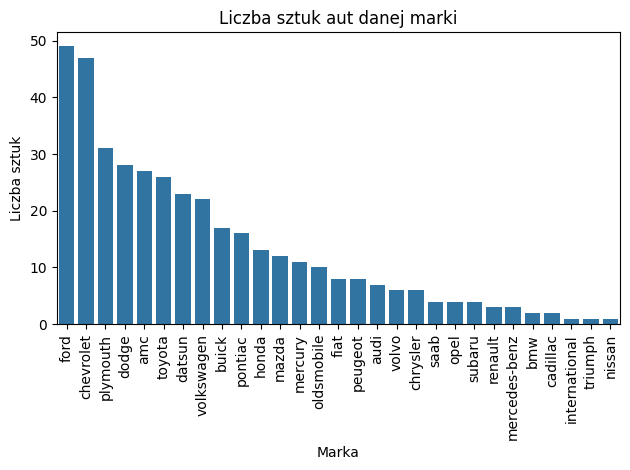

In [623]:
sns.countplot(data=df, x='brand', order=df['brand'].value_counts().index)
plt.title('Liczba sztuk aut danej marki')
plt.xlabel('Marka')
plt.ylabel('Liczba sztuk')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Sprawdzamy, czy w datasecie są wartości brakujące - nie ma

In [624]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     392 non-null    int64  
 1   displacement  392 non-null    float64
 2   horsepower    392 non-null    int64  
 3   weight        392 non-null    float64
 4   acceleration  392 non-null    float64
 5   year          392 non-null    int64  
 6   origin        392 non-null    int64  
 7   name          392 non-null    object 
 8   l/100km       392 non-null    float64
 9   region        392 non-null    object 
 10  brand         392 non-null    object 
dtypes: float64(4), int64(4), object(3)
memory usage: 33.8+ KB


In [625]:
df.isna().sum()

cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
l/100km         0
region          0
brand           0
dtype: int64

Badamy zbiór danych pod kątem zduplikowanych wierszy

In [626]:
df.duplicated().sum()

np.int64(0)

Regresja liniowa jest mało odporna na dane odstające, więc sprawdzamy dataset pod ich kątem

In [627]:
df.describe()

,cylinders,displacement,horsepower,weight,acceleration,year,origin,l/100km
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,3.192092,104.469388,1350.607653,15.541327,1975.979592,1.576531,11.248418
std,1.705783,1.711721,38.491160,385.280727,2.758864,3.683737,0.805518,3.913358
min,3.000000,1.100000,46.000000,731.600000,8.000000,1970.000000,1.000000,5.050000
25%,4.000000,1.700000,75.000000,1009.350000,13.775000,1973.000000,1.000000,8.110000
50%,4.000000,2.500000,93.500000,1271.650000,15.500000,1976.000000,1.000000,10.340000
75%,8.000000,4.525000,126.000000,1639.600000,17.025000,1979.000000,2.000000,13.840000
max,8.000000,7.500000,230.000000,2331.500000,24.800000,1982.000000,3.000000,26.140000


Analiza wartości odstających przy pomocy wykresów pudekowych

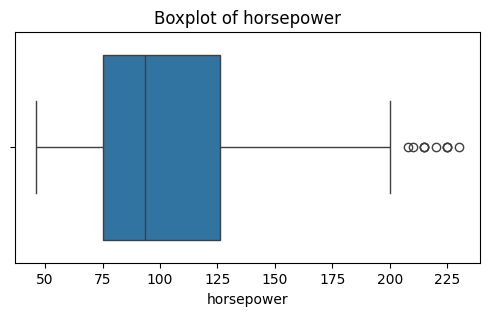

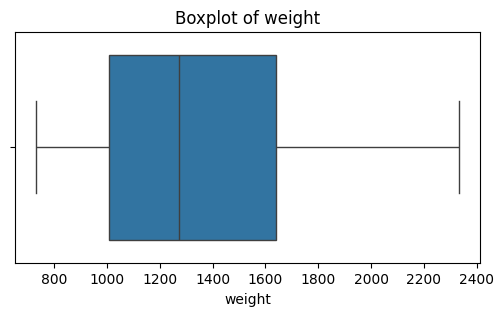

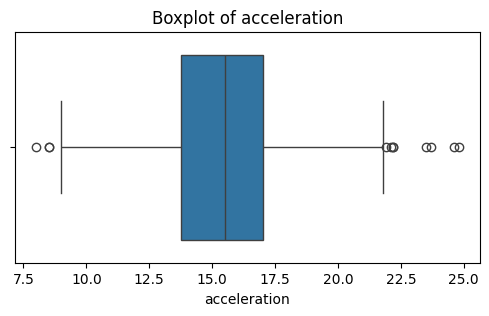

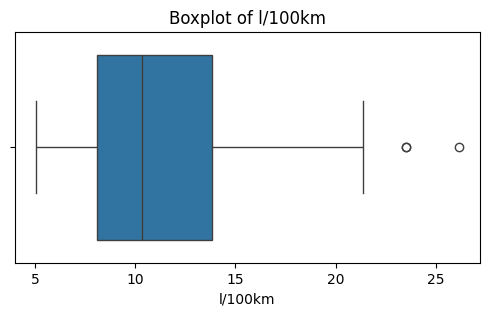

In [628]:
num_cols = ['horsepower', 'weight', 'acceleration', 'l/100km']
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

Analiza rozkladu danych na histogramach

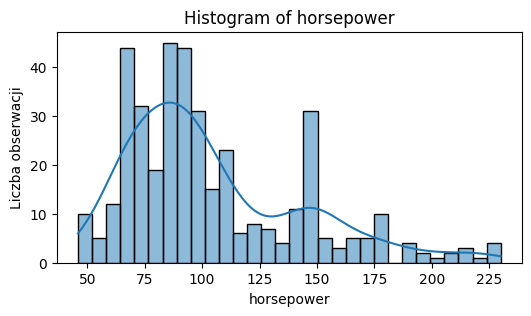

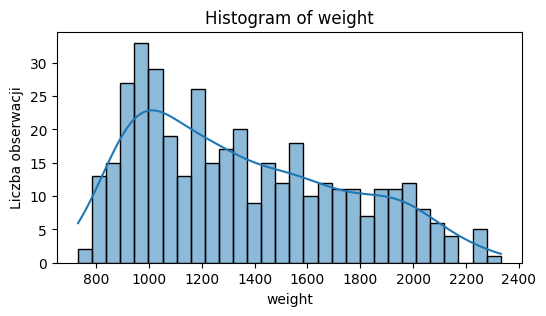

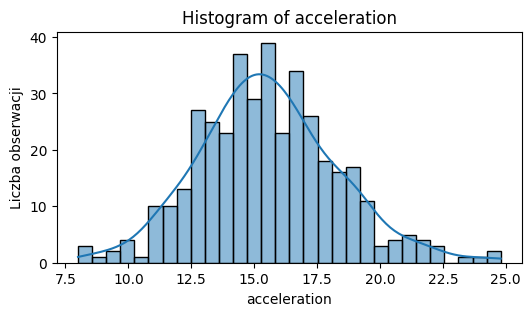

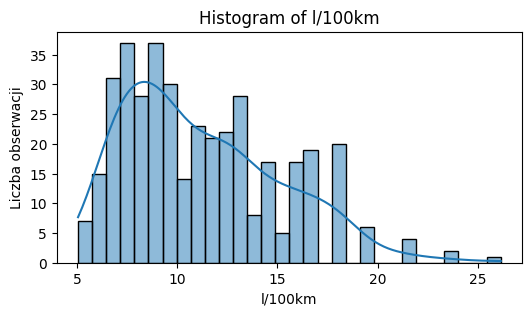

In [629]:
num_cols = ['horsepower', 'weight', 'acceleration', 'l/100km']
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Liczba obserwacji')
    plt.show()

Dane maja rozkład zbliżony do normalnego, z niewielkimi skośnościami (horsepower i l/100km). Wartości odstające są obecne, szczególnie dla horsepower i l/100km, dlatego je odrzucimy. 

In [630]:
num_cols = ['horsepower', 'l/100km']
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Przejdź przez każdą kolumnę i usuń outliery
df_clean = df.copy()
for col in num_cols:
    df_clean = remove_outliers_iqr(df_clean, col)

# Wynik
print(f"Rozmiar oryginalny: {df.shape}")
print(f"Po usunięciu outlierów: {df_clean.shape}")
df = df_clean

Rozmiar oryginalny: (392, 11)
Po usunięciu outlierów: (378, 11)


Histogramy Horsepower i l/100km po usunieciu outlierow

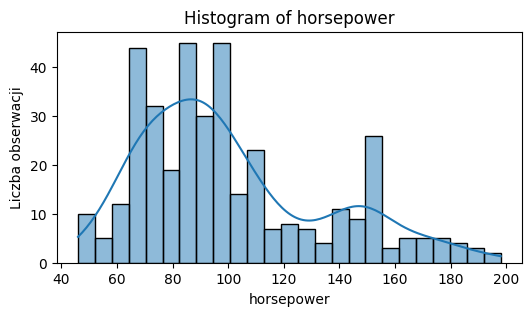

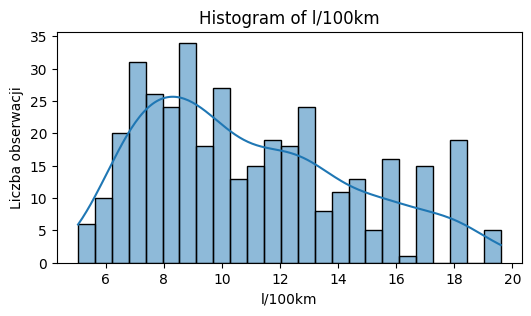

In [631]:
num_cols = ['horsepower', 'l/100km']
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df_clean[col], bins=25, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Liczba obserwacji')
    plt.show()

Dane nie wymagaja dalszej normalizacji. </br>
Zaburzenie monotoniczności w zakresie 120–150 koni mechanicznych (horsepower) jest naturalnym odzwierciedleniem rzeczywistości i nie wpłynie negatywnie na działanie modelu.

## Analiza danych

Wstępna wizualizacja zależności między liczbą koni mechanicznych (wartością numeryczną), a pozostałymi zmiennymi. Relacje z innymi wartościami numerycznymi uwidocznione na wykresach punktowych, a z kategoriami na wykresach pudełkowych

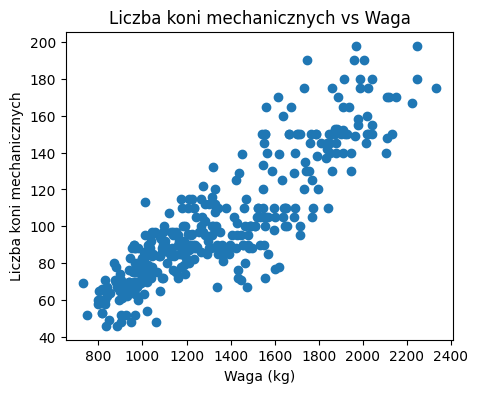

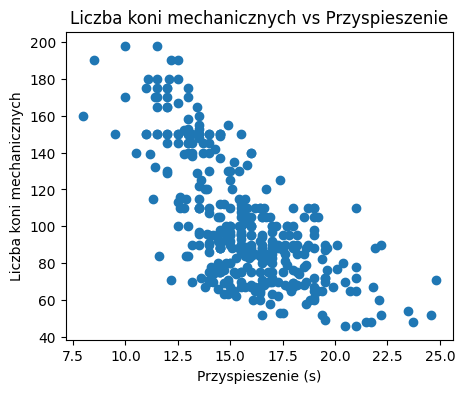

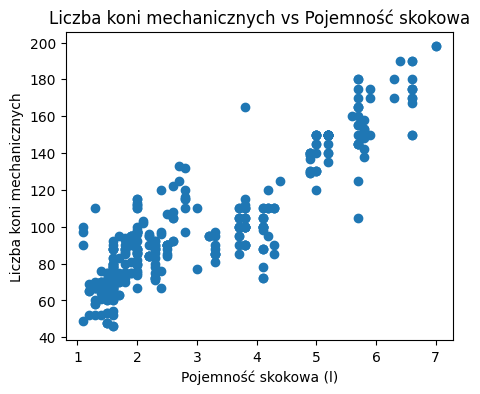

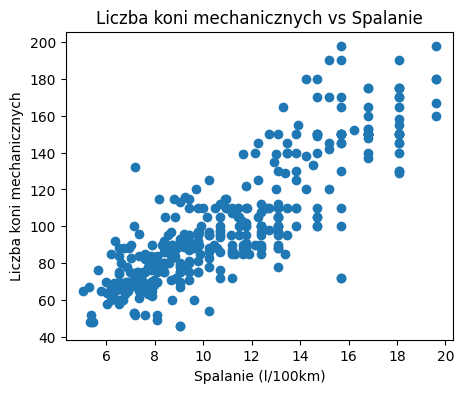

In [632]:
f, ax = plt.subplots(figsize=(5, 4))
plt.scatter(df["weight"], df["horsepower"])
plt.xlabel("Waga (kg)")
plt.ylabel("Liczba koni mechanicznych")
plt.title("Liczba koni mechanicznych vs Waga")
plt.show()

f, ax = plt.subplots(figsize=(5, 4))
plt.scatter(df["acceleration"], df["horsepower"])
plt.xlabel("Przyspieszenie (s)")
plt.ylabel("Liczba koni mechanicznych")
plt.title("Liczba koni mechanicznych vs Przyspieszenie")
plt.show()

f, ax = plt.subplots(figsize=(5, 4))
plt.scatter(df["displacement"], df["horsepower"])
plt.xlabel("Pojemność skokowa (l)")
plt.ylabel("Liczba koni mechanicznych")
plt.title("Liczba koni mechanicznych vs Pojemność skokowa")
plt.show()

f, ax = plt.subplots(figsize=(5, 4))
plt.scatter(df["l/100km"], df["horsepower"])
plt.xlabel("Spalanie (l/100km)")
plt.ylabel("Liczba koni mechanicznych")
plt.title("Liczba koni mechanicznych vs Spalanie")
plt.show()

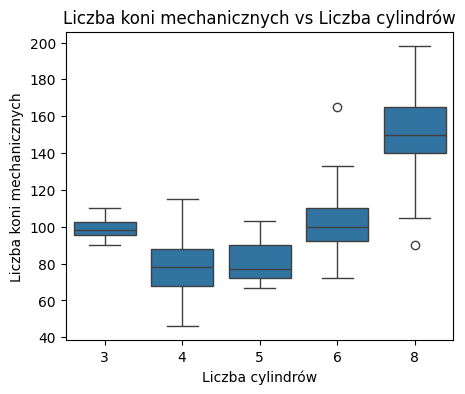

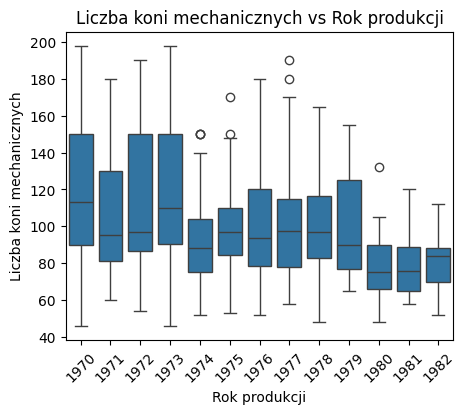

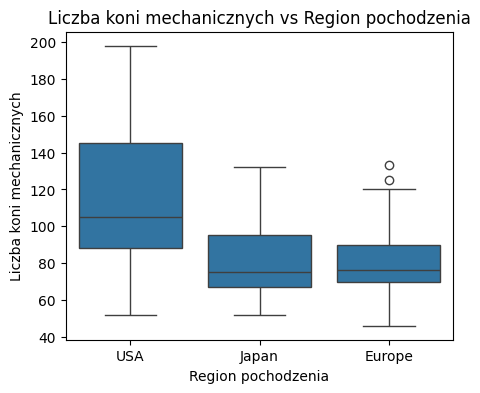

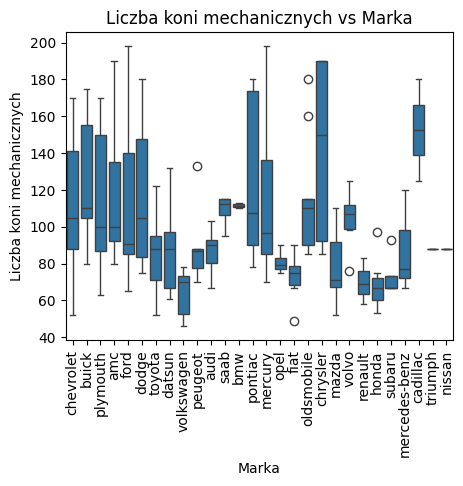

In [633]:
f, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(x='cylinders', y='horsepower', data=df)
plt.title("Liczba koni mechanicznych vs Liczba cylindrów")
plt.xlabel("Liczba cylindrów")
plt.ylabel("Liczba koni mechanicznych")
plt.show()

f, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(x='year', y='horsepower', data=df)
plt.title("Liczba koni mechanicznych vs Rok produkcji")
plt.xlabel("Rok produkcji")
plt.ylabel("Liczba koni mechanicznych")
plt.xticks(rotation=45)
plt.show()

f, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(x='region', y='horsepower', data=df)
plt.title("Liczba koni mechanicznych vs Region pochodzenia")
plt.xlabel("Region pochodzenia")
plt.ylabel("Liczba koni mechanicznych")

plt.show()

f, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(x='brand', y='horsepower', data=df)
plt.title("Liczba koni mechanicznych vs Marka")
plt.xlabel("Marka")
plt.ylabel("Liczba koni mechanicznych")
plt.xticks(rotation=90)
plt.show()

Badanie zależności między dwiema zmiennymi przy pomocy macierzy korelacji

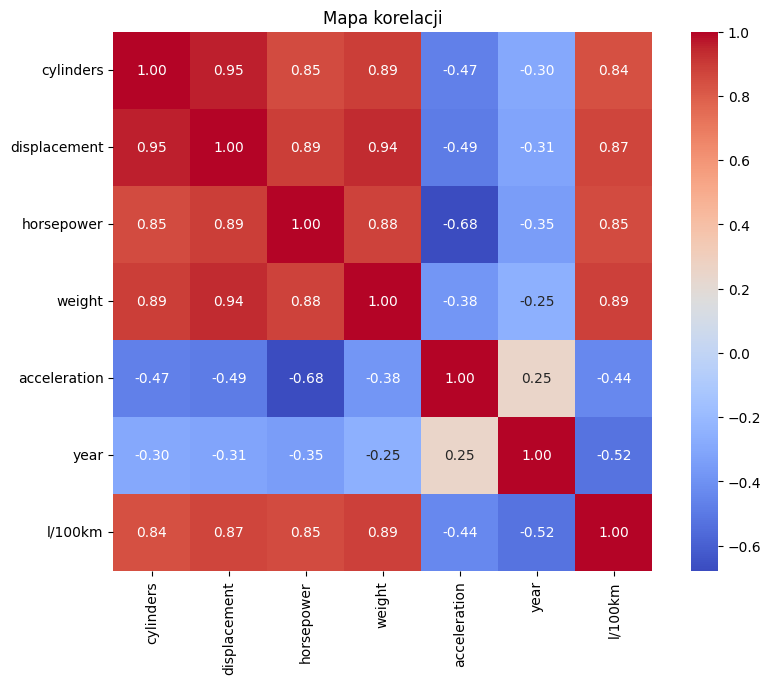

Silne korelacje z liczba koni mechanicznych (|r| ≥ 0.5):
cylinders       0.854008
displacement    0.892999
weight          0.876683
acceleration   -0.678060
l/100km         0.849502
Name: horsepower, dtype: float64


In [634]:
plt.figure(figsize=(10, 7))
corr_matrix = df.drop(columns=['name', 'brand', 'region', 'origin']).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Mapa korelacji')
plt.show()

# Wydruk silnych korelacji (|r| ≥ 0.5) z liczba koni mechanicznych
strong_corr_with_hp = corr_matrix['horsepower'][(corr_matrix['horsepower'].abs() >= 0.5) & (corr_matrix['horsepower'].abs() < 1.0)]
print("Silne korelacje z liczba koni mechanicznych (|r| ≥ 0.5):")
print(strong_corr_with_hp)

Sprawdzanie istotności statystycznej korelacji pomiędzy różnymi cechami, a liczbą koni mechanicznych

In [635]:
features = ['weight', 'acceleration', 'cylinders', 'displacement', 'l/100km', 'year']
SIGNIFICANCE_THRESHOLD = 0.05

for feature in features:
    corr_coef, p_value = pearsonr(df[feature], df['horsepower'])
    print(f"Korelacja Pearsona między '{feature}' a Liczbą koni mechanicznych: {corr_coef:.4f}")
    print(f"Wartość p: {p_value:.4f}")
    print(f"Cecha {feature}{' NIE ' if p_value > SIGNIFICANCE_THRESHOLD else ' '}jest statystycznie istotna.")
    print(f"Interpretacja: {'Słaba korelacja' if abs(corr_coef) < 0.3 else 'Umiarkowana korelacja' if abs(corr_coef) < 0.5 else 'Dość silna korelacja' if abs(corr_coef) < 0.7 else 'Silna korelacja'}.\n")

Korelacja Pearsona między 'weight' a Liczbą koni mechanicznych: 0.8767
Wartość p: 0.0000
Cecha weight jest statystycznie istotna.
Interpretacja: Silna korelacja.

Korelacja Pearsona między 'acceleration' a Liczbą koni mechanicznych: -0.6781
Wartość p: 0.0000
Cecha acceleration jest statystycznie istotna.
Interpretacja: Dość silna korelacja.

Korelacja Pearsona między 'cylinders' a Liczbą koni mechanicznych: 0.8540
Wartość p: 0.0000
Cecha cylinders jest statystycznie istotna.
Interpretacja: Silna korelacja.

Korelacja Pearsona między 'displacement' a Liczbą koni mechanicznych: 0.8930
Wartość p: 0.0000
Cecha displacement jest statystycznie istotna.
Interpretacja: Silna korelacja.

Korelacja Pearsona między 'l/100km' a Liczbą koni mechanicznych: 0.8495
Wartość p: 0.0000
Cecha l/100km jest statystycznie istotna.
Interpretacja: Silna korelacja.

Korelacja Pearsona między 'year' a Liczbą koni mechanicznych: -0.3477
Wartość p: 0.0000
Cecha year jest statystycznie istotna.
Interpretacja: Umiar

Wszystkie powyższe zmienne przedstawiają statystycznie istotne korelacje - od umiarkowanych po silne.

Skalujemy dane przed stworzeniem modelu regresji liniowej. 

In [636]:
standarized_cols = [ 'weight', 'acceleration', 'l/100km']
scaler = StandardScaler()
df[standarized_cols] = scaler.fit_transform(df[standarized_cols])  


## Budowanie modelu

Budujemy model regresji liniowej w oparciu o backward selection - zaczynamy od wszystkich zmiennych (poza tymi zmiennymi kategorycznymi, których nie możemy przedstawić w postaci numerycznej), a następnie usuwamy zmienną o największym parametrze P-value do momentu aż wszystkie zmienne mają P-value < 0.05

In [637]:
X = df.drop(columns=['horsepower', 'name', 'brand', 'region'])
y = df['horsepower']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             horsepower   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     590.2
Date:                Thu, 31 Jul 2025   Prob (F-statistic):          2.05e-196
Time:                        17:03:49   Log-Likelihood:                -1388.6
No. Observations:                 378   AIC:                             2793.
Df Residuals:                     370   BIC:                             2825.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          585.6771    376.040      1.557   

Ze względu na wysokie P-value odrzucamy liczbe cylindrow.

In [638]:
X = df.drop(columns=['horsepower', 'name', 'brand', 'region', 'cylinders'])
y = df['horsepower']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             horsepower   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     690.3
Date:                Thu, 31 Jul 2025   Prob (F-statistic):          7.81e-198
Time:                        17:03:49   Log-Likelihood:                -1388.6
No. Observations:                 378   AIC:                             2791.
Df Residuals:                     371   BIC:                             2819.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          591.7556    375.026      1.578   

Ze względu na wysokie P-value odrzucamy rok.

In [639]:
X = df.drop(columns=['horsepower', 'name', 'brand', 'region', 'cylinders', 'year'])
y = df['horsepower']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             horsepower   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     826.1
Date:                Thu, 31 Jul 2025   Prob (F-statistic):          6.47e-199
Time:                        17:03:49   Log-Likelihood:                -1389.6
No. Observations:                 378   AIC:                             2791.
Df Residuals:                     372   BIC:                             2815.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           82.8969      3.801     21.808   

W ten sposób pozbyliśmy się parametrów przekraczających wyznaczoną wartość progową P-value i poprawiliśmy wartość F-statistic.

Poniżej sprawdzamy cechy interakcyjne dla fizycznie uzasadnionych cech, czyli:

- weight * acceleration (waga może mieć wpływ na przyspieszenie)

- cylinders * displacement (ilość cylindrów powinna wpływać na pojemność skokową silnika)

- weight * displacement (większe auto = większy silnik)

- acceleration * year (im nowsze auto tym lepsze przyspieszenie)

- origin * displacement (pochodzenie auta, a więc styl projektowania może wpływać na pojemność skokową)

In [640]:
df['weight_acceleration'] = df['weight'] * df['acceleration']
df['cylinders_displacement'] = df['cylinders'] * df['displacement']
df['weight_displacement'] = df['weight'] * df['displacement']
df['acceleration_year'] = df['acceleration'] * df['year']
df['origin_displacement'] = df['origin'] * df['displacement']


In [641]:
interaction_features = ['weight_acceleration', 'cylinders_displacement', 'weight_displacement', 'acceleration_year', 'origin_displacement']

for feature in interaction_features:
    corr, _ = pearsonr(df[feature], df['horsepower'])
    print(f"Korelacja {feature} z horsepower: {corr:.3f}")


Korelacja weight_acceleration z horsepower: -0.428
Korelacja cylinders_displacement z horsepower: 0.901
Korelacja weight_displacement z horsepower: 0.876
Korelacja acceleration_year z horsepower: -0.678
Korelacja origin_displacement z horsepower: 0.611


Najsłabsza korelacja dla: *weight_acceleration*. Sprawdźmy R<sup>2</sup> bez tej cechy:

In [642]:
features = ['cylinders', 'displacement', 'weight', 'acceleration', 'l/100km',
             'cylinders_displacement', 'weight_displacement', 'acceleration_year', 'origin_displacement']

X = df[features]
y = df['horsepower']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² Score z cechami interakcyjnymi:", round(r2_score(y_test, y_pred), 3))


R² Score z cechami interakcyjnymi: 0.918


Sprawdźmy jak na R<sup>2</sup> wpłynie jednak dodanie słabo skorelowanej cechy *weight_acceleration*

In [643]:
features = ['cylinders', 'displacement', 'weight', 'acceleration', 'l/100km',
             'cylinders_displacement', 'weight_displacement', 'acceleration_year', 'origin_displacement', 'weight_acceleration']

X = df[features]
y = df['horsepower']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² Score z cechami interakcyjnymi, po dodaniu weight_acceleration:", round(r2_score(y_test, y_pred), 3))


R² Score z cechami interakcyjnymi, po dodaniu weight_acceleration: 0.925


Nieznacznie, ale jednak dodanie cechy poprawiło nam R<sup>2</sup> do wartości 0.925. Wskazuje to na ukrytą współzależność z pozostałymi zmiennymi.

In [644]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

selected_features = ['cylinders', 'displacement', 'weight', 'acceleration', 'l/100km',
             'cylinders_displacement', 'weight_displacement', 'acceleration_year', 'origin_displacement', 'weight_acceleration']


X = df[selected_features]
y = df['horsepower']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Finalny R² Score:", round(r2_score(y_test, y_pred), 3))
print("Finalne MSE:", round(mean_squared_error(y_test, y_pred), 2))
print("Finalne MAE:", round(mean_absolute_error(y_test, y_pred), 2))


Finalny R² Score: 0.925
Finalne MSE: 109.73
Finalne MAE: 7.71


Model osiągnął R² = 0.925, co oznacza, że model wyjaśni 92.5% różnic w liczbie koni mechanicznych między autami tylko za pomocą danych wejściowych. 
Średni błąd bezwzględny to ok. 7.71 KM, a średni kwadratowy błąd to 109.73, co świadczy o dobrej precyzji modelu regresji liniowej.

Analiza reszt

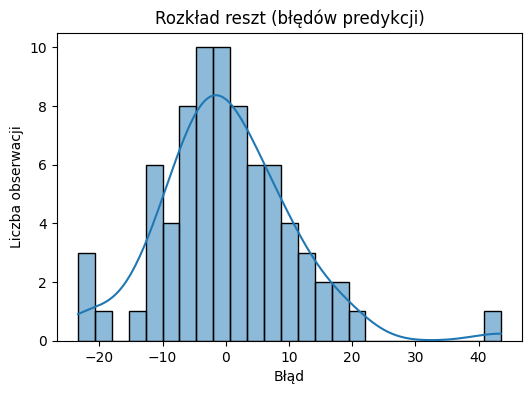

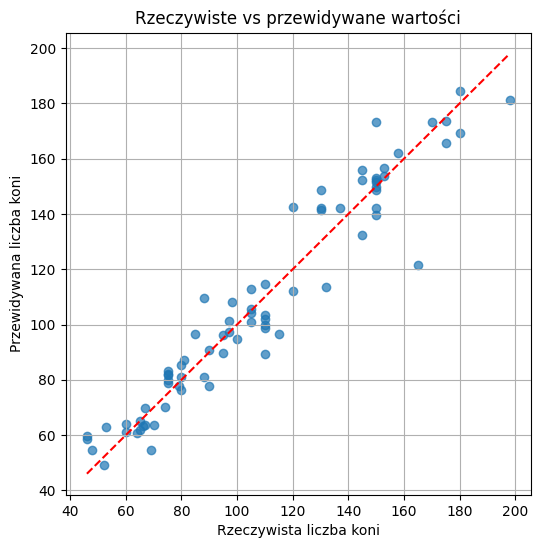

In [657]:
residuals = y_test - y_pred

# Rozkład reszt
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25)
plt.title("Rozkład reszt (błędów predykcji)")
plt.xlabel("Błąd")
plt.ylabel("Liczba obserwacji")
plt.show()

# Rzeczywiste vs przewidywane
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Rzeczywista liczba koni")
plt.ylabel("Przewidywana liczba koni")
plt.title("Rzeczywiste vs przewidywane wartości")
plt.grid(True)
plt.show()
  


Rozkład reszt jest zbliżony do rozkładu normalnego, a przewidywane wartości sa bliskie rzeczywistym. 

## Podsumowanie



Model regresji liniowej został wytrenowany w celu przewidywania liczby koni mechanicznych (`horsepower`) na podstawie cech technicznych samochodów oraz stworzonych cech interakcyjnych. 

Po analizie korelacji i fizycznie uzasadnionych kombinacji, wybrano zestaw 10 cech wejściowych. Model osiągnął:

- R²: **0.925**
- MAE: **7.71**
- MSE: **109.73**

Dodatkowo, analiza reszt oraz wykres przewidywań wskazują na brak poważnych błędów systematycznych, co potwierdza dobre dopasowanie modelu.

Model może być użyty jako predyktor mocy silnika na podstawie danych technicznych.


## Przykladowe użycie modelu: funkcja predykcji

In [658]:
def predict_horsepower(model, scaler, input_dict):
    # Podstawowe cechy
    cylinders = input_dict.get('cylinders', 4)
    displacement = input_dict.get('displacement', 2)
    weight = input_dict.get('weight', 1500)
    acceleration = input_dict.get('acceleration', 17)
    l_100km = input_dict.get('l/100km', 10)
    year = input_dict.get('year', 1970)
    origin = input_dict.get('origin', 1)

    # Standaryzacja cech numerycznych z zachowaniem nazw kolumn
    num_cols = ['weight', 'acceleration', 'l/100km']
    num_df = pd.DataFrame([[weight, acceleration, l_100km]], columns=num_cols)
    weight_std, acceleration_std, l_100km_std = scaler.transform(num_df)[0]

    # Oblicz cechy interakcyjne na standaryzowanych wartościach
    weight_acceleration = weight_std * acceleration_std
    cylinders_displacement = cylinders * displacement
    weight_displacement = weight_std * displacement
    acceleration_year = acceleration_std * year
    origin_displacement = origin * displacement

    # Przygotuj DataFrame
    row = {
        'cylinders': cylinders,
        'displacement': displacement,
        'weight': weight_std,
        'acceleration': acceleration_std,
        'l/100km': l_100km_std,
        'cylinders_displacement': cylinders_displacement,
        'weight_displacement': weight_displacement,
        'acceleration_year': acceleration_year,
        'origin_displacement': origin_displacement,
        'weight_acceleration': weight_acceleration,
    }
    X_new = pd.DataFrame([row])

    # Predykcja
    pred = model.predict(X_new)[0]
    return pred

In [659]:
# Przykład użycia:
input_dict = {
    'cylinders': 4,
    'displacement': 2,
    'weight': 1500,
    'acceleration': 8,
    'l/100km': 12,
}
wynik = predict_horsepower(model, scaler, input_dict)
print("Przewidywana liczba koni mechanicznych:", round(wynik, 1))

Przewidywana liczba koni mechanicznych: 148.6
